In [1]:
import numpy as np
import pandas as pd
from bankrupt import *
pd.set_option('display.max_columns', 100)

# Load Data

In [2]:
# Loads .arff files from directory and concats into a single dataframe
# No longer needed after data is written to csv
# df = load_and_combine_files()

# Splits dataset into training/validation and final test sets
# No longer needed after train/val and test sets are written to csv
# train_df, test_df = create_train_and_final_test_sets(df=df)

In [3]:
train_df = pd.read_csv("./datasets/train_20221010_1821.csv")
test_df = pd.read_csv("./datasets/test_20221010_1821.csv")

In [19]:
train_df.head()

,net_profit_/_total_assets,total_liabilities_/_total_assets,working_capital_/_total_assets,current_assets_/_short-term_liabilities,(cash_+_short-term_securities_+_receivables_-_short-term_liabilities)_/_(operating_expenses_-_depreciation)_*_365,retained_earnings_/_total_assets,EBIT_/_total_assets,book_value_of_equity_/_total_liabilities,sales_/_total_assets,equity_/_total_assets,(gross_profit_+_extraordinary_items_+_financial_expenses)_/_total_assets,gross_profit_/_short-term_liabilities,(gross_profit_+_depreciation)_/_sales,(gross_profit_+_interest)_/_total_assets,(total_liabilities_*_365)_/_(gross_profit_+_depreciation),(gross_profit_+_depreciation)_/_total_liabilities,total_assets_/_total_liabilities,gross_profit_/_total_assets,gross_profit_/_sales,(inventory_*_365)_/_sales,sales_(n)_/_sales_(n-1),profit_on_operating_activities_/_total_assets,net_profit_/_sales,gross_profit_(in_3_years)_/_total_assets,(equity_-_share_capital)_/_total_assets,(net_profit_+_depreciation)_/_total_liabilities,profit_on_operating_activities_/_financial_expenses,working_capital_/_fixed_assets,logarithm_of_total_assets,(total_liabilities_-_cash)_/_sales,(gross_profit_+_interest)_/_sales,(current_liabilities_*_365)_/_cost_of_products_sold,operating_expenses_/_short-term_liabilities,operating_expenses_/_total_liabilities,profit_on_sales_/_total_assets,total_sales_/_total_assets,(current_assets_-_inventories)_/_long-term_liabilities,constant_capital_/_total_assets,profit_on_sales_/_sales,(current_assets_-_inventory_-_receivables)_/_short-term_liabilities,total_liabilities_/_((profit_on_operating_activities_+_depreciation)_*_(12/365)),profit_on_operating_activities_/_sales,rotation_receivables_+_inventory_turnover_in_days,(receivables_*_365)_/_sales,net_profit_/_inventory,(current_assets_-_inventory)_/_short-term_liabilities,(inventory_*_365)_/_cost_of_products_sold,EBITDA_(profit_on_operating_activities_-_depreciation)_/_total_assets,EBITDA_(profit_on_operating_activities_-_depreciation)_/_sales,current_assets_/_total_liabilities,short-term_liabilities_/_total_assets,(short-term_liabilities_*_365)_/_cost_of_products_sold),equity_/_fixed_assets,constant_capital_/_fixed_assets,working_capital,(sales_-_cost_of_products_sold)_/_sales,(current_assets_-_inventory_-_short-term_liabilities)_/_(sales_-_gross_profit_-_depreciation),total_costs_/total_sales,long-term_liabilities_/_equity,sales_/_inventory,sales_/_receivables,(short-term_liabilities_*365)_/_sales,sales_/_short-term_liabilities,sales_/_fixed_assets,bankrupt,year_number
0,-0.036574,0.64459,0.030193,1.0468,-23.6790,0.015256,-0.045800,0.50279,1.0046,0.32409,-0.045800,-0.071053,0.003475,-0.045800,37181.00,0.009817,1.5514,-0.045800,-0.025156,27.1860,1.0520,-0.011462,-0.020088,0.019509,0.32409,0.024130,-0.063243,0.092837,4.8482,0.335820,-0.025156,129.810,2.8117,-0.017782,-0.011462,1.83600,NaN,0.32409,-0.006295,0.067532,0.521120,-0.006295,126.550,99.364,-0.269710,0.83646,27.310,-0.063590,-0.034927,1.0468,0.64459,0.35566,0.99652,0.99652,2128.40,0.004550,-0.112850,0.99545,0.000000,13.4260,3.6734,129.220,2.8246,5.59820,0,2
1,0.019585,0.48434,0.383310,3.1530,39.3190,0.000000,0.019585,1.06470,1.4777,0.51566,0.021596,0.110010,0.391730,0.019585,305.39,1.195200,2.0647,0.019585,0.013254,101.3400,NaN,0.000000,0.013254,0.019585,0.50304,1.195200,0.000000,0.873810,3.8019,0.277290,0.027443,363.430,1.0043,0.369170,0.017738,1.47770,0.58918,0.77204,0.012004,0.500790,0.028867,0.000000,116.630,15.288,0.047735,0.84845,837.540,-0.559290,-0.378480,1.1590,0.17803,0.99570,1.17550,1.76000,2429.20,0.879000,0.037981,0.12415,0.497180,3.6017,23.8740,43.975,8.3002,3.36870,0,1
2,-0.045354,0.66269,0.187200,1.3725,-7.5979,0.000000,-0.045354,0.50899,4.5079,0.33731,-0.014310,-0.090243,0.008930,-0.045354,6008.80,0.060745,1.5090,-0.045354,-0.010061,21.5540,NaN,-0.032554,-0.010061,-0.045354,0.28442,0.060745,-1.048700,0.603430,3.6151,0.113510,-0.008191,40.252,9.0680,6.876900,-0.049431,4.50790,5.45600,0.41494,-0.010966,0.331070,0.416360,-0.007

In [21]:
train_df['bankrupt'].value_counts(normalize=True)

0    0.951823
1    0.048177
Name: bankrupt, dtype: float64

# EDA

# Baseline Models

In [4]:
baseline_models = [LGBMClassifier(random_state=7742, n_jobs=10), 
                   XGBClassifier(random_state=7742, n_jobs=10),
                   RandomForestClassifier(random_state=7742, n_jobs=10), 
                   DummyClassifier(strategy="most_frequent")]

impute_strategies=["knn5", 
                   "knn20", 
                   "knn30", 
                   "knn40", 
                   "knn100", 
                   "knn150", 
                   "mean", 
                   "median", 
                   "drop"]

# No need to rerun this - results read in from csv
#
# base_df = get_all_baseline_model_performances(df=train_df, 
#                                               random_state=7742,
#                                               target_column="bankrupt", 
#                                               impute_strategies=impute_strategies,
#                                               estimators=baseline_models, 
#                                               metrics=['f1', 'balanced_accuracy', 
#                                                        'roc_auc', 'accuracy', 
#                                                        'recall', 'precision'], 
#                                               n_jobs=50)

# timestamp = time.strftime("%Y%m%d_%H%M",time.localtime())
# base_df.to_csv(f"./models/baseline_model_performance_{timestamp}.csv", index=False)

base_df = pd.read_csv("./models/baseline_model_performance_20221010_2203.csv")
base_df.head(10)

,model,impute_strategy,fit_time_mean,score_time_mean,test_f1_mean,test_f1_min,test_f1_max,test_f1_std,train_f1_mean,train_f1_min,train_f1_max,train_f1_std,test_balanced_accuracy_mean,test_balanced_accuracy_min,test_balanced_accuracy_max,test_balanced_accuracy_std,train_balanced_accuracy_mean,train_balanced_accuracy_min,train_balanced_accuracy_max,train_balanced_accuracy_std,test_roc_auc_mean,test_roc_auc_min,test_roc_auc_max,test_roc_auc_std,train_roc_auc_mean,train_roc_auc_min,train_roc_auc_max,train_roc_auc_std,test_accuracy_mean,test_accuracy_min,test_accuracy_max,test_accuracy_std,train_accuracy_mean,train_accuracy_min,train_accuracy_max,train_accuracy_std,test_recall_mean,test_recall_min,test_recall_max,test_recall_std,train_recall_mean,train_recall_min,train_recall_max,train_recall_std,test_precision_mean,test_precision_min,test_precision_max,test_precision_std,train_precision_mean,train_precision_min,train_precision_max,train_precision_std,fit_time_min,fit_time_max,fit_time_std,score_time_min,score_time_max,score_time_std,num_rows_dropped
0,"XGBClassifier(base_score=None, booster=None, c...",mean,8.495721,0.024762,0.736953,0.682432,0.782609,0.032459,0.995641,0.994659,0.997633,0.001014,0.801728,0.766389,0.834031,0.021007,0.995689,0.994687,0.997639,0.000991,0.974237,0.966733,0.981825,0.005000,0.999999,0.999997,1.000000,7.588898e-07,0.979265,0.975941,0.982079,0.002113,0.999582,0.999488,0.999772,0.000097,0.605257,0.534392,0.670213,0.042076,0.991380,0.989374,0.995277,0.001980,0.944874,0.916031,0.981481,0.022040,0.999940,0.999404,1.000000,0.000179,5.685204,9.907172,1.479865,0.015626,0.035686,0.007881,0
1,"XGBClassifier(base_score=None, booster=None, c...",median,10.429644,0.022807,0.736887,0.681967,0.787500,0.029082,0.993939,0.991662,0.996445,0.001441,0.801223,0.773519,0.834299,0.017918,0.993978,0.991731,0.996458,0.001424,0.975275,0.964434,0.981771,0.005068,0.999999,0.999998,1.000000,7.163471e-07,0.979265,0.975173,0.982591,0.002001,0.999420,0.999204,0.999659,0.000137,0.604193,0.550265,0.670213,0.035716,0.987956,0.983461,0.992916,0.002847,0.946184,0.896552,0.991071,0.024533,1.000000,1.000000,1.000000,0.000000,7.236293,11.877904,1.652963,0.007505,0.035688,0.008172,0
2,"LGBMClassifier(n_jobs=10, random_state=7742)",mean,1.604570,0.023959,0.735393,0.706667,0.775641,0.020339,0.913366,0.910026,0.919108,0.002642,0.797480,0.778717,0.821405,0.013876,0.920768,0.918148,0.925870,0.002237,0.973720,0.962845,0.980065,0.004559,0.999650,0.999554,0.999770,6.642503e-05,0.979367,0.977476,0.982079,0.001265,0.992309,0.992036,0.992775,0.000216,0.596198,0.558511,0.643617,0.027969,0.841598,0.836385,0.851830,0.004474,0.961163,0.928571,0.990741,0.017232,0.998530,0.997191,1.000000,0.000855,0.518799,1.946440,0.403089,0.015622,0.039977,0.008627,0
3,"LGBMClassifier(n_jobs=10, random_state=7742)",median,0.904061,0.025838,0.721775,0.687285,0.759740,0.023333,0.905756,0.900907,0.914030,0.003516,0.789695,0.765554,0.810767,0.014827,0.914639,0.910749,0.922003,0.002963,0.974385,0.964693,0.982120,0.005175,0.999599,0.999447,0.999726,8.668695e-05,0.978471,0.976703,0.981055,0.001462,0.991686,0.991296,0.992349,0.000284,0.580789,0.531915,0.622340,0.029762,0.829377,0.821618,0.844156,0.005930,0.955028,0.926829,0.975000,0.018430,0.997657,0.996431,0.998584,0.000776,0.643224,1.062583,0.167273,0.022005,0.033019,0.004385,0
4,"XGBClassifier(base_score=None, booster=None, c...",knn150,88.061234,17.946950,0.659291,0.631944,0.701639,0.020441,0.987013,0.980746,0.991967,0.003236,0.755325,0.739665,0.783230,0.012997,0.987217,0.981110,0.992031,0.003180,0.961436,0.949644,0.966882,0.004997,0.999988,0.999954,0.999998,1.463522e-05,0.974503,0.972606,0.976703,0.001260,0.998766,0.998180,0.999232,0.000303,0.512774,0.481481,0.569149,0.026366,0.974436,0.962220,0.984061,0.006364,0.925825,0.881818,0.979167,0.031177,0.999940,0.999399,1.000000,0.000180,82.314906,91.380677,2.855434,15.102284,19.641390,1.482171,0
5,"XGBClassifier(base_score=None, booster=None, c...",knn100,83.601981,16.602148,0.647494

# Hyperparameter Tuning

In [5]:
# from sklearn.feature_selection import SelectPercentile, mutual_info_classif, SelectKBest

# feature_selector = SelectKBest(score_func=mutual_info_classif)

# pipe = Pipeline(steps=[("impute", SimpleImputer(strategy="mean")), 
#                        ("selector", feature_selector),
#                        ("model", LGBMClassifier(random_state=7742, 
#                                                 n_jobs=20))])

pipe = Pipeline(steps=[("impute", SimpleImputer(strategy="mean")), 
                       ("model", LGBMClassifier(random_state=7742, 
                                                n_jobs=20, ))])

parameter_grid = {"model__n_estimators":[100, 750, 1000], 
                  "model__class_weight":["balanced", None], 
                  "model__max_depth":[-1, 10],
                  "model__boosting_type":["gbdt", "dart"], 
                  "model__colsample_bytree":[1.0, 0.95], 
                  "model__subsample":[1.0, 0.95], 
                  "model__num_leaves":[30,31,32], 
                  "model__learning_rate":np.logspace(start=-2.7, stop=-0.3, num=25)}
                                             
# gs1 = run_gridsearch(X=X, 
#                      y=y, 
#                      folds=10,
#                      estimator=pipe, 
#                      param_grid=parameter_grid, 
#                      n_jobs=60,
#                      scoring= ['f1', 'balanced_accuracy', 'roc_auc', 'accuracy', 'recall', 'precision'], 
#                      save_name=get_gs_save_name(model_name=f"LGBM"))

PATH=f"./models/LGBM_20221010_2255.pkl"
gs1 = load_gs_from_pickle(pickle_filepath=PATH)
gs1_df = gs_to_clean_df(gs1.cv_results_, sort_metric="mean_test_f1")
gs1_df.loc[:,[c for c in gs1_df.columns if "std" not in c]].head()

,boosting_type,class_weight,colsample_bytree,learning_rate,max_depth,n_estimators,num_leaves,subsample,params,mean_test_f1,rank_test_f1,mean_train_f1,mean_test_balanced_accuracy,rank_test_balanced_accuracy,mean_train_balanced_accuracy,mean_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,rank_test_accuracy,mean_train_accuracy,mean_test_recall,rank_test_recall,mean_train_recall,mean_test_precision,rank_test_precision,mean_train_precision
4478,dart,balanced,1.0,0.501187,-1,1000,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.797211,1,0.999941,0.851388,2487,0.999997,0.981855,159,1.0,0.982772,1,0.999994,0.706032,3055,1.0,0.916519,3135,0.999882
4479,dart,balanced,1.0,0.501187,-1,1000,31,0.95,"{'model__boosting_type': 'dart', 'model__class...",0.797211,1,0.999941,0.851388,2487,0.999997,0.981855,159,1.0,0.982772,1,0.999994,0.706032,3055,1.0,0.916519,3135,0.999882
4456,dart,balanced,1.0,0.398107,10,750,32,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.796537,3,0.999941,0.851386,2489,0.999997,0.980359,961,1.0,0.982721,3,0.999994,0.706080,3053,1.0,0.915065,3173,0.999882
4457,dart,balanced,1.0,0.398107,10,750,32,0.95,"{'model__boosting_type': 'dart', 'model__class...",0.796537,3,0.999941,0.851386,2489,0.999997,0.980359,961,1.0,0.982721,3,0.999994,0.706080,3053,1.0,0.915065,3173,0.999882
4387,dart,balanced,1.0,0.251189,10,1000,30,0.95,"{'model__boosting_type': 'dart', 'model__class...",0.795907,5,0.999941,0.854836,2279,0.999997,0.980723,741,1.0,0.982439,39,0.999994,0.713626,2917,1.0,0.901032,3631,0.999882


In [6]:
print(f"Best Average Validation F1-Score: {gs1.best_score_}\n\nBest Parameters:\n{gs1.best_params_}")

Best Average Validation F1-Score: 0.797211267331267

Best Parameters:
{'model__boosting_type': 'dart', 'model__class_weight': 'balanced', 'model__colsample_bytree': 1.0, 'model__learning_rate': 0.5011872336272722, 'model__max_depth': -1, 'model__n_estimators': 1000, 'model__num_leaves': 31, 'model__subsample': 1.0}


In [7]:
pipe = Pipeline(steps=[("impute", SimpleImputer(strategy="mean")), 
                       ("model", LGBMClassifier(random_state=7742, 
                                                n_jobs=20))])

parameter_grid = {"model__n_estimators":[1000, 1300], 
                  "model__class_weight":["balanced"], 
                  "model__max_depth":[-1],
                  "model__boosting_type":["dart"], 
                  "model__colsample_bytree":[1.0], 
                  "model__subsample":[1.0], 
                  "model__num_leaves":[31], 
                  "model__learning_rate":np.logspace(start=-0.6, stop=-0.0, num=25)}


# gs2 = run_gridsearch(X=X, 
#                      y=y, 
#                      folds=10,
#                      estimator=pipe, 
#                      param_grid=parameter_grid, 
#                      n_jobs=60,
#                      scoring= ['f1', 'balanced_accuracy', 'roc_auc', 'accuracy', 'recall', 'precision'], 
#                      save_name=get_gs_save_name(model_name=f"LGBM_Dart"))

PATH=f"./models/LGBM_Dart_20221011_1603.pkl"
gs2 = load_gs_from_pickle(pickle_filepath=PATH)
gs2_df = gs_to_clean_df(gs2.cv_results_, sort_metric="mean_test_f1")
gs2_df.loc[:,[c for c in gs2_df.columns if "std" not in c]].head()

,boosting_type,class_weight,colsample_bytree,learning_rate,max_depth,n_estimators,num_leaves,subsample,params,mean_test_f1,rank_test_f1,mean_train_f1,mean_test_balanced_accuracy,rank_test_balanced_accuracy,mean_train_balanced_accuracy,mean_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,rank_test_accuracy,mean_train_accuracy,mean_test_recall,rank_test_recall,mean_train_recall,mean_test_precision,rank_test_precision,mean_train_precision
35,dart,balanced,1.0,0.668344,-1,1300,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.799391,1,0.999941,0.855455,2,0.999997,0.978852,39,1.0,0.982798,1,0.999994,0.714570,2,1.0,0.908829,21,0.999882
2,dart,balanced,1.0,0.266073,-1,1000,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.797916,2,0.999941,0.855501,1,0.999997,0.980313,26,1.0,0.982593,3,0.999994,0.714876,1,1.0,0.903545,31,0.999882
24,dart,balanced,1.0,0.501187,-1,1000,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.797211,3,0.999941,0.851388,9,0.999997,0.981855,3,1.0,0.982772,2,0.999994,0.706032,9,1.0,0.916519,2,0.999882
34,dart,balanced,1.0,0.668344,-1,1000,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.795486,4,0.999941,0.852336,5,0.999997,0.979861,34,1.0,0.982516,6,0.999994,0.708305,6,1.0,0.908383,22,0.999882
12,dart,balanced,1.0,0.354813,-1,1000,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.795242,5,0.999941,0.851494,8,0.999997,0.980741,16,1.0,0.982542,5,0.999994,0.706486,8,1.0,0.911202,10,0.999882


In [8]:
print(f"Best Average Validation F1-Score: {gs2.best_score_}\n\nBest Parameters:\n{gs2.best_params_}")

Best Average Validation F1-Score: 0.7993908655040464

Best Parameters:
{'model__boosting_type': 'dart', 'model__class_weight': 'balanced', 'model__colsample_bytree': 1.0, 'model__learning_rate': 0.6683439175686147, 'model__max_depth': -1, 'model__n_estimators': 1300, 'model__num_leaves': 31, 'model__subsample': 1.0}


In [9]:
pipe = Pipeline(steps=[("impute", SimpleImputer(strategy="mean")), 
                       ("model", LGBMClassifier(random_state=7742, 
                                                n_jobs=20))])

parameter_grid = {"model__n_estimators":[1300, 1500, 2000, 2500], 
                  "model__class_weight":["balanced"], 
                  "model__max_depth":[-1],
                  "model__boosting_type":["dart"], 
                  "model__colsample_bytree":[1.0], 
                  "model__subsample":[1.0], 
                  "model__num_leaves":[31], 
                  "model__learning_rate":np.logspace(start=-0.6, stop=-0.0, num=25)}


# gs3 = run_gridsearch(X=X, 
#                      y=y, 
#                      folds=10,
#                      estimator=pipe, 
#                      param_grid=parameter_grid, 
#                      n_jobs=60,
#                      scoring= ['f1', 'balanced_accuracy', 'roc_auc', 'accuracy', 'recall', 'precision'], 
#                      save_name=get_gs_save_name(model_name=f"LGBM_Dart_large"))

PATH=f"./models/LGBM_Dart_large_20221011_1628.pkl"
gs3 = load_gs_from_pickle(pickle_filepath=PATH)
gs3_df = gs_to_clean_df(gs3.cv_results_, sort_metric="mean_test_f1")
gs3_df.loc[:,[c for c in gs3_df.columns if "std" not in c]].head()

,boosting_type,class_weight,colsample_bytree,learning_rate,max_depth,n_estimators,num_leaves,subsample,params,mean_test_f1,rank_test_f1,mean_train_f1,mean_test_balanced_accuracy,rank_test_balanced_accuracy,mean_train_balanced_accuracy,mean_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,rank_test_accuracy,mean_train_accuracy,mean_test_recall,rank_test_recall,mean_train_recall,mean_test_precision,rank_test_precision,mean_train_precision
68,dart,balanced,1.0,0.668344,-1,1300,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.799391,1,0.999941,0.855455,2,0.999997,0.978852,65,1.0,0.982798,1,0.999994,0.714570,3,1.0,0.908829,40,0.999882
49,dart,balanced,1.0,0.501187,-1,1500,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.796883,2,0.999941,0.851991,10,0.999997,0.981702,17,1.0,0.982695,2,0.999994,0.707400,12,1.0,0.913187,13,0.999882
69,dart,balanced,1.0,0.668344,-1,1500,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.796429,3,0.999941,0.853737,5,0.999997,0.978902,64,1.0,0.982567,3,0.999994,0.711216,6,1.0,0.906693,50,0.999882
62,dart,balanced,1.0,0.595662,-1,2000,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.795185,4,0.999941,0.852401,6,0.999997,0.978082,70,1.0,0.982490,6,0.999994,0.708460,8,1.0,0.907490,48,0.999882
63,dart,balanced,1.0,0.595662,-1,2500,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.795174,5,0.999941,0.854439,3,0.999997,0.976966,77,1.0,0.982414,13,0.999994,0.712860,5,1.0,0.900858,67,0.999882


In [10]:
print(f"Best Average Validation F1-Score: {gs3.best_score_}\n\nBest Parameters:\n{gs3.best_params_}")

Best Average Validation F1-Score: 0.7993908655040464

Best Parameters:
{'model__boosting_type': 'dart', 'model__class_weight': 'balanced', 'model__colsample_bytree': 1.0, 'model__learning_rate': 0.6683439175686147, 'model__max_depth': -1, 'model__n_estimators': 1300, 'model__num_leaves': 31, 'model__subsample': 1.0}


In [11]:
best_learning_rate = gs3.best_params_['model__learning_rate']
lower = best_learning_rate - (best_learning_rate*0.25)
upper = best_learning_rate + (best_learning_rate*0.25)
learning_rate_search = np.linspace(start=lower, 
                                   stop=upper, 
                                   num=500).tolist() + [best_learning_rate]

pipe = Pipeline(steps=[("impute", SimpleImputer(strategy="mean")), 
                       ("model", LGBMClassifier(random_state=7742, 
                                                n_jobs=20))])

parameter_grid = {"model__n_estimators":[1300], 
                  "model__class_weight":["balanced"], 
                  "model__max_depth":[-1],
                  "model__boosting_type":["dart"], 
                  "model__colsample_bytree":[1.0], 
                  "model__subsample":[1.0], 
                  "model__num_leaves":[31], 
                  "model__learning_rate":learning_rate_search}


# gs4 = run_gridsearch(X=X, 
#                      y=y, 
#                      folds=10,
#                      estimator=pipe, 
#                      param_grid=parameter_grid, 
#                      n_jobs=60,
#                      scoring= ['f1', 'balanced_accuracy', 'roc_auc', 'accuracy', 'recall', 'precision'], 
#                      save_name=get_gs_save_name(model_name=f"LGBM_Dart_gs4_learning_rate"))

PATH=f"./models/LGBM_Dart_gs4_learning_rate_20221011_2135.pkl"
gs4 = load_gs_from_pickle(pickle_filepath=PATH)
gs4_df = gs_to_clean_df(gs4.cv_results_, sort_metric="mean_test_f1")
gs4_df.loc[:,[c for c in gs4_df.columns if "std" not in c]].head()

,boosting_type,class_weight,colsample_bytree,learning_rate,max_depth,n_estimators,num_leaves,subsample,params,mean_test_f1,rank_test_f1,mean_train_f1,mean_test_balanced_accuracy,rank_test_balanced_accuracy,mean_train_balanced_accuracy,mean_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,rank_test_accuracy,mean_train_accuracy,mean_test_recall,rank_test_recall,mean_train_recall,mean_test_precision,rank_test_precision,mean_train_precision
500,dart,balanced,1.0,0.668344,-1,1300,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.799391,1,0.999941,0.855455,1,0.999997,0.978852,303,1.0,0.982798,3,0.999994,0.714570,7,1.0,0.908829,93,0.999882
46,dart,balanced,1.0,0.532063,-1,1300,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.798263,2,0.999941,0.852660,16,0.999997,0.980898,46,1.0,0.982823,1,0.999994,0.708628,34,1.0,0.915385,5,0.999882
97,dart,balanced,1.0,0.566217,-1,1300,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.797838,3,0.999941,0.851866,44,0.999997,0.980952,37,1.0,0.982798,2,0.999994,0.706988,65,1.0,0.916868,2,0.999882
239,dart,balanced,1.0,0.661312,-1,1300,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.797512,4,0.999941,0.853357,10,0.999997,0.979361,244,1.0,0.982670,9,0.999994,0.710266,20,1.0,0.910433,55,0.999882
74,dart,balanced,1.0,0.550815,-1,1300,31,1.0,"{'model__boosting_type': 'dart', 'model__class...",0.797333,5,0.999941,0.853490,8,0.999997,0.981256,21,1.0,0.982670,8,0.999994,0.710559,19,1.0,0.909660,66,0.999882


In [12]:
print(f"Best Average Validation F1-Score: {gs4.best_score_}\n\nBest Parameters:\n{gs4.best_params_}")

Best Average Validation F1-Score: 0.7993908655040464

Best Parameters:
{'model__boosting_type': 'dart', 'model__class_weight': 'balanced', 'model__colsample_bytree': 1.0, 'model__learning_rate': 0.6683439175686147, 'model__max_depth': -1, 'model__n_estimators': 1300, 'model__num_leaves': 31, 'model__subsample': 1.0}


# Model Evaluation

## Training Set Performance

In [13]:
train_df["bankrupt"].value_counts(normalize=True)

0    0.951823
1    0.048177
Name: bankrupt, dtype: float64

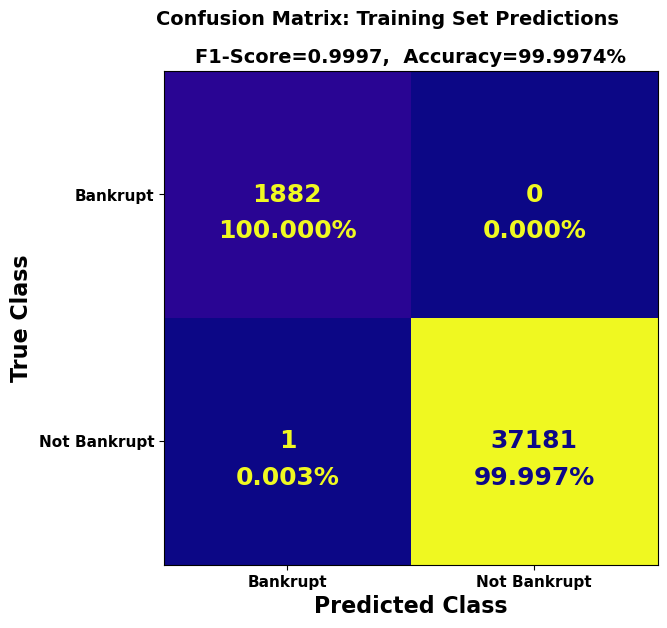

In [14]:
axis = plot_confusion_matrix_from_estimator(df=train_df, 
                                            target="bankrupt", 
                                            model=gs4, 
                                            display_labels=["Bankrupt", "Not Bankrupt"], 
                                            format_digits_annots=3, 
                                            save_path="./images/train_confusion_matrix.png")

## Final Test Set Performance

In [15]:
test_df['bankrupt'].value_counts(normalize=True)

0    0.951854
1    0.048146
Name: bankrupt, dtype: float64

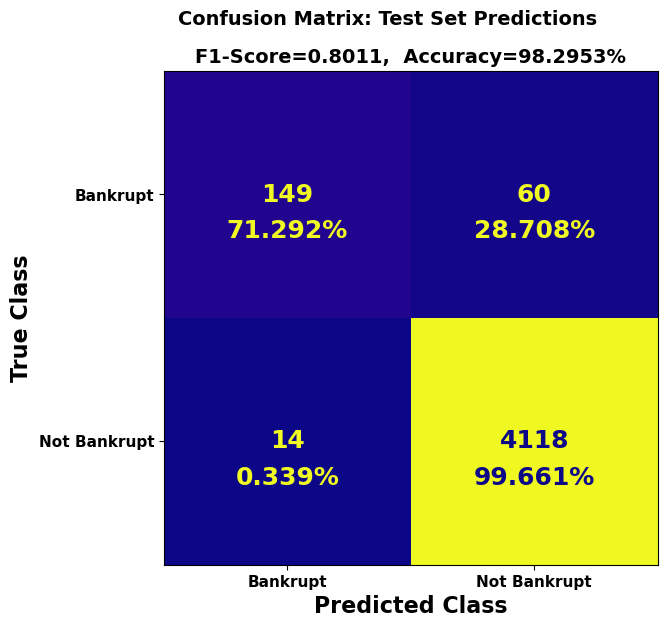

In [16]:
axis = plot_confusion_matrix_from_estimator(df=test_df, 
                                            target="bankrupt", 
                                            model=gs4, 
                                            display_labels=["Bankrupt", "Not Bankrupt"],  
                                            title="Confusion Matrix: Test Set Predictions",
                                            format_digits_annots=3, 
                                            save_path="./images/test_confusion_matrix.png")

## Feature Importance

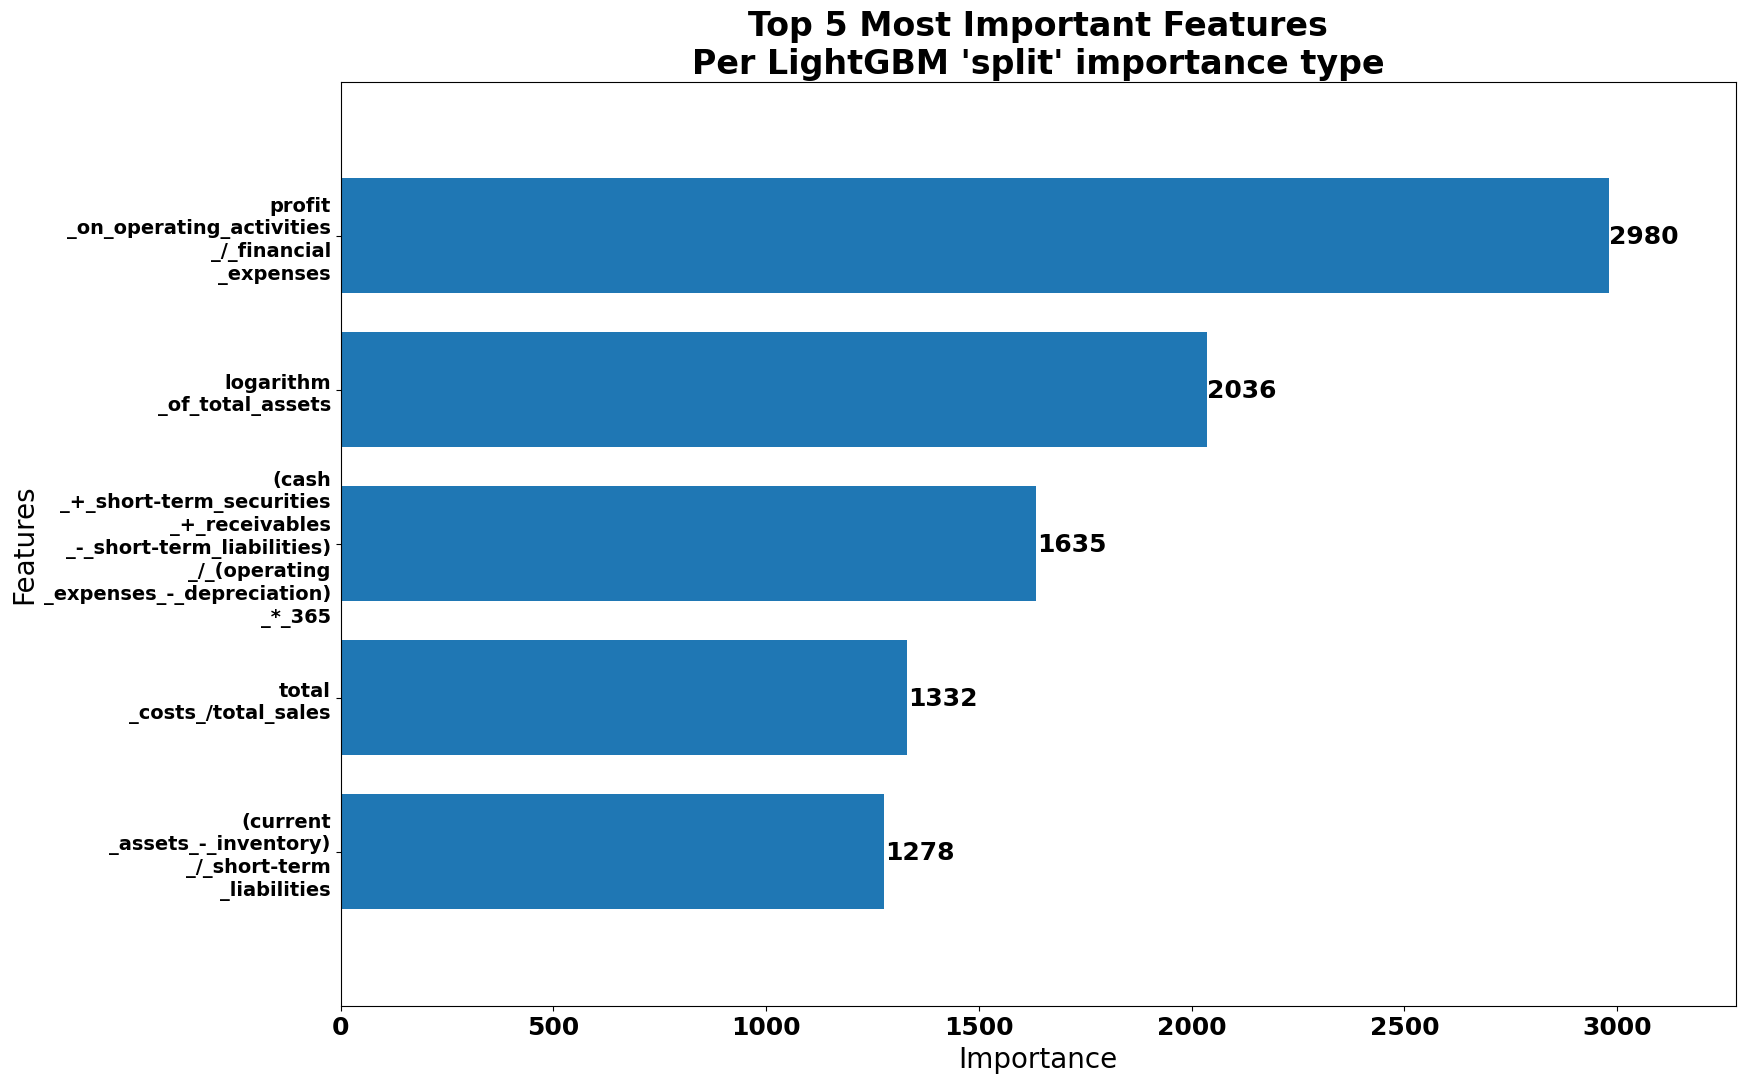

In [17]:
axis = plot_lgbm_feature_importance_from_gs(gs=gs4, 
                                            importance_type="split", 
                                            ytick_fontsize=14, 
                                            save_path="./images/top5_split_importance.png")

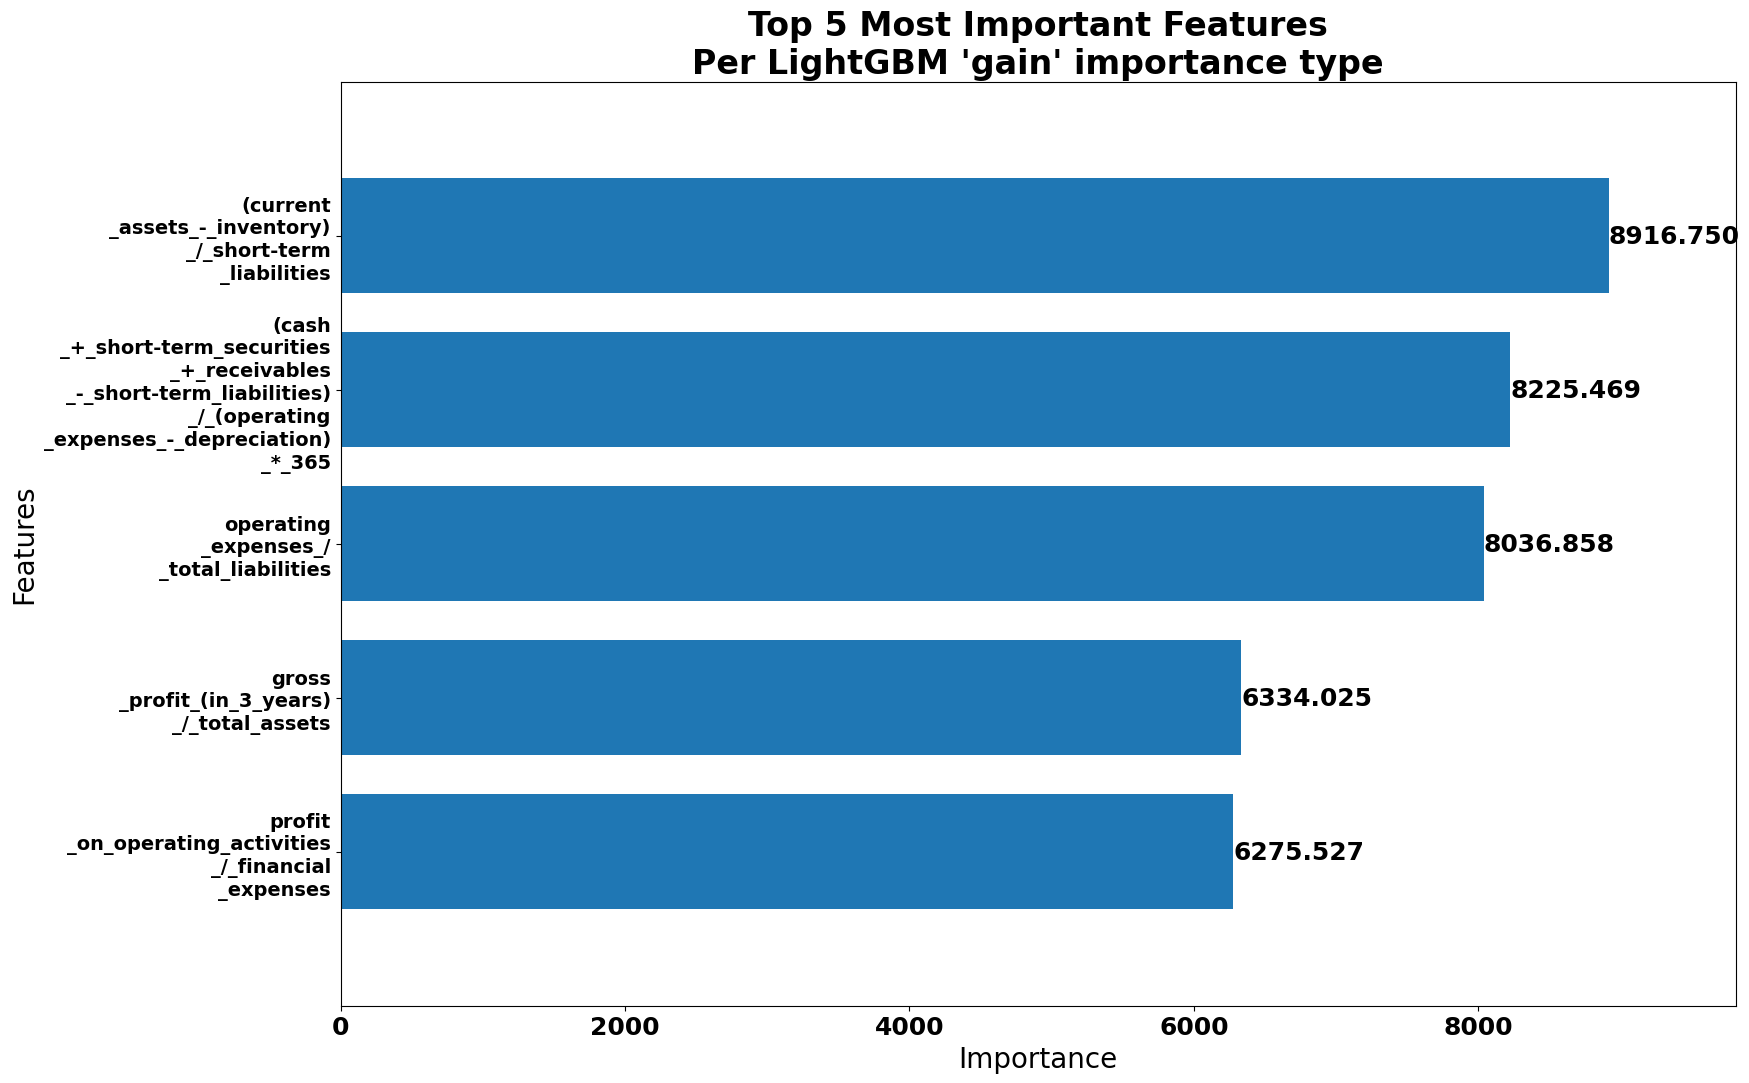

In [18]:
axis = plot_lgbm_feature_importance_from_gs(gs=gs4, 
                                            importance_type="gain", 
                                            ytick_fontsize=14, 
                                            save_path="./images/top5_gain_importance.png")

In [ ]:
# 1) Boruta --> features
#
# 2) subset to features
#
# 3) get probabilities 
#
# 4) 

In [ ]:
# 